# 📊 CNN Model for 5G Throughput Prediction
**Target**: Smoothed `Throughput`

- Based on CNN for temporal feature extraction
- Includes rolling window sequence generation
- Uses smoothed `Throughput` as prediction target
- Evaluation: predicted vs true vs original throughput


In [1]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


### 🔹 1. Load and preprocess the dataset

In [2]:

# Corrected local path
df = pd.read_csv(r"D:\\4DATA\SEMESTER2\PI\DATASET\mm-5G.csv")

# Apply smoothing on the throughput column
df['Throughput_smoothed'] = df['Throughput'].rolling(window=5, min_periods=1).mean()


### 🔹 2. Normalize and prepare sequences for CNN input

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# ---- 1. Preprocessing ----

# One-hot encode categorical columns (e.g. 'mobility_mode', 'nrStatus', etc.)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Identify numeric features (excluding targets)
numeric_features = df.select_dtypes(include=[np.number]).columns.drop(['Throughput', 'Throughput_smoothed'])

# Scale only numeric features
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Final feature list for training
features = numeric_features

# ---- 2. Custom Dataset ----

class TimeSeriesCnnDataset(Dataset):
    def __init__(self, df, input_len=48, output_len=1):
        self.X, self.y = [], []
        for i in range(len(df) - input_len - output_len + 1):
            x = df[features].iloc[i:i+input_len].values.T  # shape: (features, timesteps)
            y = df['Throughput_smoothed'].iloc[i+input_len:i+input_len+output_len].values
            self.X.append(x)
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---- 3. Prepare DataLoader ----

input_len = 48
output_len = 1

dataset = TimeSeriesCnnDataset(df, input_len, output_len)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)


### 🔹 3. Define CNN model

In [8]:

class CNNModel(nn.Module):
    def __init__(self, in_channels, seq_len, output_len):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32, output_len)

    def forward(self, x):
        x = self.relu(self.conv1(x))       # (batch, 32, seq_len)
        x = self.pool(x)                   # (batch, 32, 1)
        x = self.flatten(x)                # (batch, 32)
        x = self.fc(x)                     # (batch, output_len)
        return x

model = CNNModel(in_channels=len(features), seq_len=input_len, output_len=output_len)


### 🔹 4. Train the model

In [10]:

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []

for epoch in range(25):
    model.train()
    batch_losses = []
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

    model.eval()
    with torch.no_grad():
        val_loss = np.mean([loss_fn(model(xb), yb).item() for xb, yb in val_dl])
        val_losses.append(val_loss)

    f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}"


### 🔹 5. Plot loss evolution

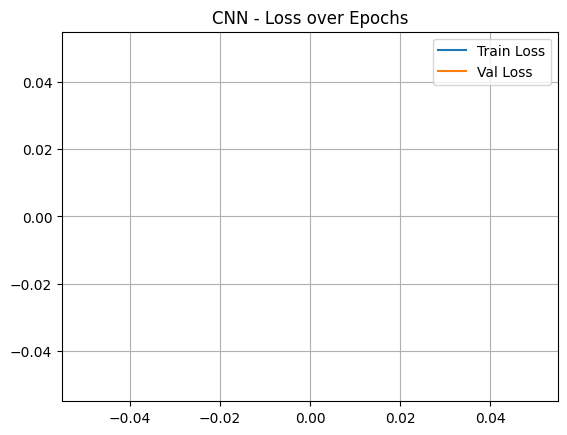

In [12]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("CNN - Loss over Epochs")
plt.grid(True)
plt.show()


### 🔹 6. Final prediction vs truth vs original throughput

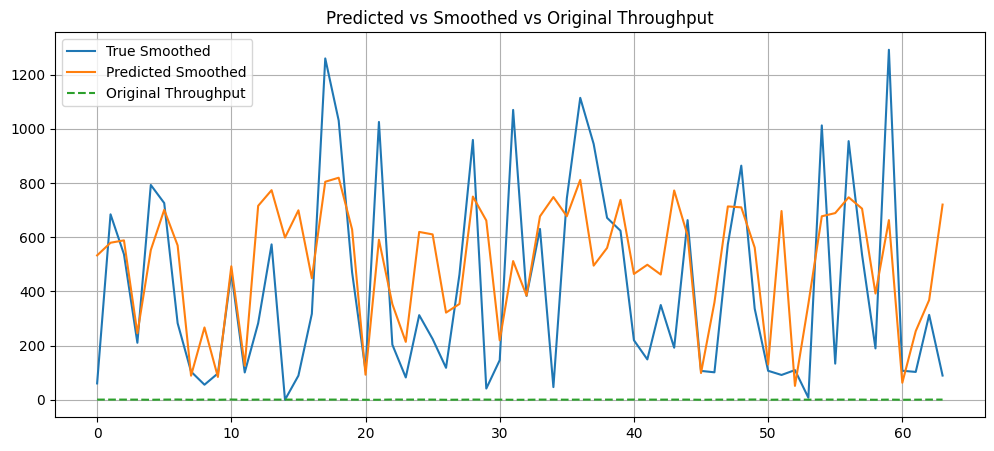

In [13]:

model.eval()
xbatch, ytrue = next(iter(val_dl))
with torch.no_grad():
    ypred = model(xbatch).squeeze().numpy()

plt.figure(figsize=(12,5))
plt.plot(ytrue.squeeze().numpy(), label='True Smoothed')
plt.plot(ypred, label='Predicted Smoothed')
plt.plot(xbatch[:, -1, df.columns.get_loc('Throughput') - 2].numpy(), label='Original Throughput', linestyle='--')
plt.title('Predicted vs Smoothed vs Original Throughput')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

model.eval()
all_preds, all_targets = [], []
skipped_batches = 0

with torch.no_grad():
    for xb, yb in val_dl:
        # Validate shape and NaN
        valid_x = ~torch.isnan(xb).any(dim=(1, 2))
        valid_y = ~torch.isnan(yb).any(dim=1)
        valid_indices = valid_x & valid_y

        if valid_indices.sum() == 0:
            skipped_batches += 1
            continue

        xb = xb[valid_indices]
        yb = yb[valid_indices]

        preds = model(xb)

        # Fix shape (e.g., [64, 1] -> [64])
        if preds.ndim > 1 and preds.shape[1] == 1:
            preds = preds.squeeze(1)
        if yb.ndim > 1 and yb.shape[1] == 1:
            yb = yb.squeeze(1)

        preds_np = preds.cpu().numpy()
        targets_np = yb.cpu().numpy()

        mask = ~np.isnan(preds_np) & ~np.isnan(targets_np)

        if mask.sum() == 0:
            skipped_batches += 1
            continue

        all_preds.extend(preds_np[mask])
        all_targets.extend(targets_np[mask])

# Convert to arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Final check
if all_preds.size == 0 or all_targets.size == 0:
    print(f"⚠️ All batches were skipped due to NaNs. Skipped batches: {skipped_batches}")
  
else:
    # Compute metrics
    rmse = root_mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    # Print
    print(f"\n✅ Evaluation Metrics on Validation Set:")
    print(f"📉 RMSE: {rmse:.4f}")
    print(f"📉 MAE : {mae:.4f}")
    print(f"📈 R²  : {r2:.4f}")


⚠️ All batches were skipped due to NaNs. Skipped batches: 213
